Part 3 concerns non symmetric distributions, such as chi-squared distributed errors. They are of interest because they are non-symmetric and positive.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

https://en.wikipedia.org/wiki/Skew_normal_distribution

Also, the previous functions are refactored. A more general function is used here.

In [358]:
import numpy as np
import matplotlib.pyplot as plt

In [359]:
iterations = 10000
n = 30
secret_beta = 2

It is good to refactor everything into functions! Avoid repeated code!

In [360]:
var_u_list = [0, 1.5, 2, 2.5,3.0,4.5,6.0,8.0,10.0]
var_eps_list = [1.5, 2, 2.5]

def experiment(distribution_label, gen_err_u, gen_err_eps):
    print(f"{distribution_label} distributed epsilon")
    
    beta_dict = {}
    sigma_dict = {}

    for var_u in var_u_list:
        for var_eps in var_eps_list:
            bias_beta = np.array([])
            sqerr_beta = np.array([])
            bias_beta_adj = np.array([])
            sqerr_beta_adj = np.array([])

            bias_sigma = np.array([])
            bias_sigma_adj = np.array([])
            bias_sigma_adj_v2 = np.array([])

            for _ in range(iterations):
                x = np.linspace(-20,20,n)
                if var_u > 0:
                    x_obs = x + gen_err_u(var_u, n)
                else:
                    x_obs = x
                y = x*secret_beta + gen_err_x(var_eps, n)

                beta_est = np.cov(x_obs, y)[0][1]/np.var(x_obs, ddof=1)
                beta_est_adj = np.cov(x_obs, y)[0][1]/np.var(x_obs, ddof=1) * np.var(x_obs, ddof=1)/(np.var(x_obs, ddof=1) - var_u)
                
                vx = np.var(x_obs, ddof=1) - var_u
                vu = var_u
                l = vx/(vx+vu);

                sigma_est = np.sum((y - beta_est * x_obs) ** 2) / (n-1)
                sigma_est_adj = np.sum((y - beta_est_adj * x_obs) ** 2) / (n-1)
                sigma_est_adj_v2 = np.sum((y - beta_est * x_obs) ** 2) / (n-1) - (1-l)**2*beta_est_adj**2*vx - l**2*beta_est_adj**2*vu

                bias_beta = np.append(bias_beta, (beta_est-secret_beta))
                sqerr_beta = np.append(sqerr_beta, (beta_est-secret_beta)**2)
                bias_beta_adj = np.append(bias_beta_adj, (beta_est_adj-secret_beta))
                sqerr_beta_adj = np.append(sqerr_beta_adj, (beta_est_adj-secret_beta)**2)

                bias_sigma = np.append(bias_sigma, sigma_est-var_eps)
                bias_sigma_adj = np.append(bias_sigma_adj, sigma_est_adj-var_eps)
                bias_sigma_adj_v2 = np.append(bias_sigma_adj_v2, sigma_est_adj_v2-var_eps)

            print("var_u=%.2f, var_eps=%.2f:  Unadjusted: Bias = %f, MSE = %f; Sigma bias = %f"%(var_u, var_eps, bias_beta.mean(), sqerr_beta.mean(), bias_sigma.mean()))

            print("var_u=%.2f, var_eps=%.2f:  Adjusted:   Bias = %f, MSE = %f; Sigma bias = %f"%(var_u, var_eps, bias_beta_adj.mean(), sqerr_beta_adj.mean(), bias_sigma_adj.mean()))
        
            beta_dict[(var_u, var_eps)] = {}
            beta_dict[(var_u, var_eps)]['bias_ols'] = bias_beta.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols'] = sqerr_beta.mean()
            beta_dict[(var_u, var_eps)]['bias_ols_corr'] = bias_beta_adj.mean()
            beta_dict[(var_u, var_eps)]['sqerr_ols_corr'] = sqerr_beta_adj.mean()
            
            sigma_dict[(var_u, var_eps)] = {}
            sigma_dict[(var_u, var_eps)]['bias_ols'] = bias_sigma.mean()
            sigma_dict[(var_u, var_eps)]['bias_ols_corr'] = bias_sigma_adj.mean()
            sigma_dict[(var_u, var_eps)]['bias_ols_corr_v2'] = bias_sigma_adj_v2.mean()
        
    return beta_dict, sigma_dict

In [361]:
def show_plot(title, dicts, x_label, key1, key2, y_min, y_max):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(var_u_list), len(var_eps_list), figsize=(15,30))

    for i in range(len(var_u_list)):
        for j in range(len(var_eps_list)):
            labels = x_label
            vals1 = [ d[(var_u_list[i], var_eps_list[j])][key1] for d in dicts]
            vals2 = [ d[(var_u_list[i], var_eps_list[j])][key2] for d in dicts]
            
            x = np.arange(len(labels))  # the label locations
            width = 0.35  # the width of the bars
            
            axs[i,j].set_title(title + ': $\\sigma^2_u=%.2f$, $\\sigma^2_\\epsilon=%.2f$'%(var_u_list[i], var_eps_list[j]))
            axs[i,j].bar(x - width/2, vals1, width, label="OLS")
            axs[i,j].bar(x + width/2, vals2, width, label="MME")
            axs[i,j].set_xticks(x)
            axs[i,j].set_xticklabels(labels)
            axs[i,j].legend()
            
            # axs[i,j].bar(x_label,vals,color=['tab:blue', 'tab:orange', 'tab:green'][:len(dicts)])
            axs[i][j].set_ylim(y_min, y_max)
            
    plt.subplots_adjust(hspace=0.3)

    plt.show()

Perform experiments

In [362]:
def gen_err_x(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

def gen_err_eps(var, n):
    return np.random.normal(scale=np.sqrt(var), size=n)

beta_dict_normal, sigma_dict_normal = experiment("Normal", gen_err_x, gen_err_eps)

Normal distributed epsilon
var_u=0.00, var_eps=1.50:  Unadjusted: Bias = -0.000260, MSE = 0.000352; Sigma bias = 0.003842
var_u=0.00, var_eps=1.50:  Adjusted:   Bias = -0.000260, MSE = 0.000352; Sigma bias = 0.003842
var_u=0.00, var_eps=2.00:  Unadjusted: Bias = 0.000151, MSE = 0.000470; Sigma bias = 0.001169
var_u=0.00, var_eps=2.00:  Adjusted:   Bias = 0.000151, MSE = 0.000470; Sigma bias = 0.001169
var_u=0.00, var_eps=2.50:  Unadjusted: Bias = -0.000176, MSE = 0.000588; Sigma bias = -0.015810
var_u=0.00, var_eps=2.50:  Adjusted:   Bias = -0.000176, MSE = 0.000588; Sigma bias = -0.015810
var_u=1.50, var_eps=1.50:  Unadjusted: Bias = -0.018436, MSE = 0.002040; Sigma bias = 5.947088
var_u=1.50, var_eps=1.50:  Adjusted:   Bias = 0.001772, MSE = 0.001795; Sigma bias = 6.012011
var_u=1.50, var_eps=2.00:  Unadjusted: Bias = -0.018079, MSE = 0.002136; Sigma bias = 5.979832
var_u=1.50, var_eps=2.00:  Adjusted:   Bias = 0.002132, MSE = 0.001907; Sigma bias = 6.044822
var_u=1.50, var_eps=2.50:

In [363]:
def gen_err_x(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n) # var=df/(df-2)

def gen_err_eps(var, n):
    return np.random.standard_t(df=2*var/(var-1), size=n)

beta_dict_t, sigma_dict_t = experiment("Student-T", gen_err_x, gen_err_eps)

Student-T distributed epsilon
var_u=0.00, var_eps=1.50:  Unadjusted: Bias = 0.000252, MSE = 0.000351; Sigma bias = -0.017613
var_u=0.00, var_eps=1.50:  Adjusted:   Bias = 0.000252, MSE = 0.000351; Sigma bias = -0.017613
var_u=0.00, var_eps=2.00:  Unadjusted: Bias = 0.000114, MSE = 0.000478; Sigma bias = 0.021226
var_u=0.00, var_eps=2.00:  Adjusted:   Bias = 0.000114, MSE = 0.000478; Sigma bias = 0.021226
var_u=0.00, var_eps=2.50:  Unadjusted: Bias = -0.000105, MSE = 0.000594; Sigma bias = 0.003006
var_u=0.00, var_eps=2.50:  Adjusted:   Bias = -0.000105, MSE = 0.000594; Sigma bias = 0.003006
var_u=1.50, var_eps=1.50:  Unadjusted: Bias = -0.018889, MSE = 0.002102; Sigma bias = 5.951603
var_u=1.50, var_eps=1.50:  Adjusted:   Bias = 0.001307, MSE = 0.001841; Sigma bias = 6.016423
var_u=1.50, var_eps=2.00:  Unadjusted: Bias = -0.018368, MSE = 0.002126; Sigma bias = 5.932054
var_u=1.50, var_eps=2.00:  Adjusted:   Bias = 0.001832, MSE = 0.001884; Sigma bias = 5.996800
var_u=1.50, var_eps=2.50

In [364]:
def gen_err_x(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0# var=2*dof

def gen_err_eps(var, n):
    return np.random.chisquare(df=var/2.0, size=n) - var/2.0

beta_dict_chi, sigma_dict_chi = experiment("ChiSq", gen_err_x, gen_err_eps)

ChiSq distributed epsilon
var_u=0.00, var_eps=1.50:  Unadjusted: Bias = 0.000052, MSE = 0.000343; Sigma bias = -0.026466
var_u=0.00, var_eps=1.50:  Adjusted:   Bias = 0.000052, MSE = 0.000343; Sigma bias = -0.026466
var_u=0.00, var_eps=2.00:  Unadjusted: Bias = -0.000356, MSE = 0.000458; Sigma bias = 0.000735
var_u=0.00, var_eps=2.00:  Adjusted:   Bias = -0.000356, MSE = 0.000458; Sigma bias = 0.000735
var_u=0.00, var_eps=2.50:  Unadjusted: Bias = 0.000112, MSE = 0.000573; Sigma bias = -0.029472
var_u=0.00, var_eps=2.50:  Adjusted:   Bias = 0.000112, MSE = 0.000573; Sigma bias = -0.029472
var_u=1.50, var_eps=1.50:  Unadjusted: Bias = -0.018676, MSE = 0.002253; Sigma bias = 5.970900
var_u=1.50, var_eps=1.50:  Adjusted:   Bias = 0.001529, MSE = 0.002006; Sigma bias = 6.035814
var_u=1.50, var_eps=2.00:  Unadjusted: Bias = -0.018591, MSE = 0.002347; Sigma bias = 5.908483
var_u=1.50, var_eps=2.00:  Adjusted:   Bias = 0.001609, MSE = 0.002105; Sigma bias = 5.973271
var_u=1.50, var_eps=2.50: 

Plot the results for comparison

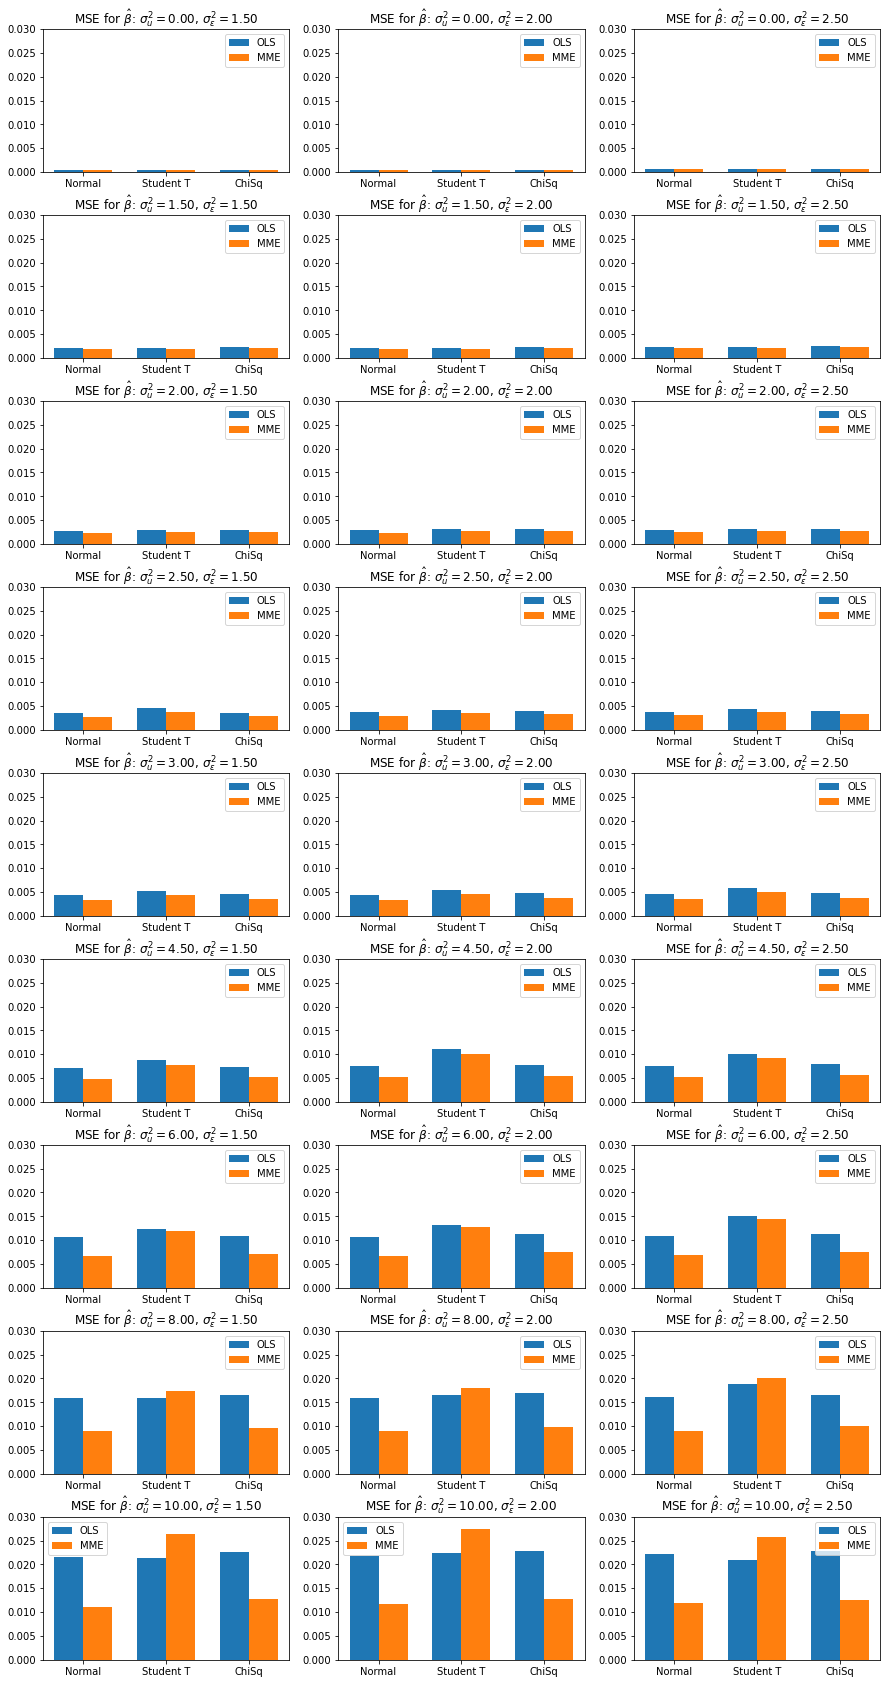

In [365]:
show_plot("MSE for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'sqerr_ols', 'sqerr_ols_corr', 0, 0.03)

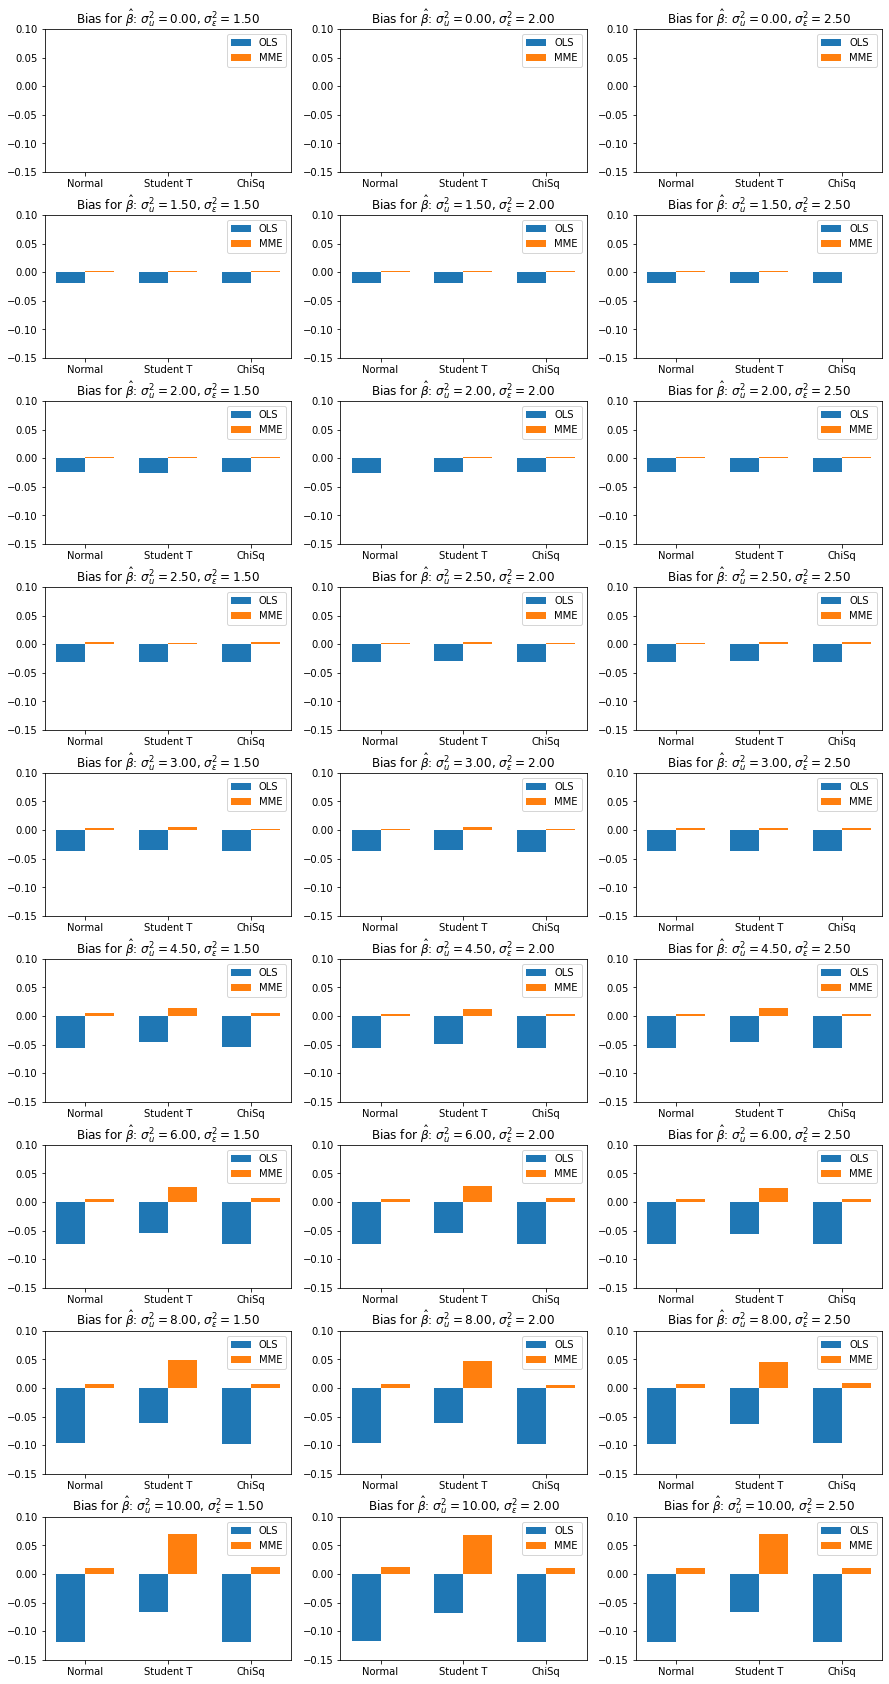

In [366]:
show_plot("Bias for $\\hat{\\beta}$", [beta_dict_normal, beta_dict_t, beta_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr', -0.15, 0.1)

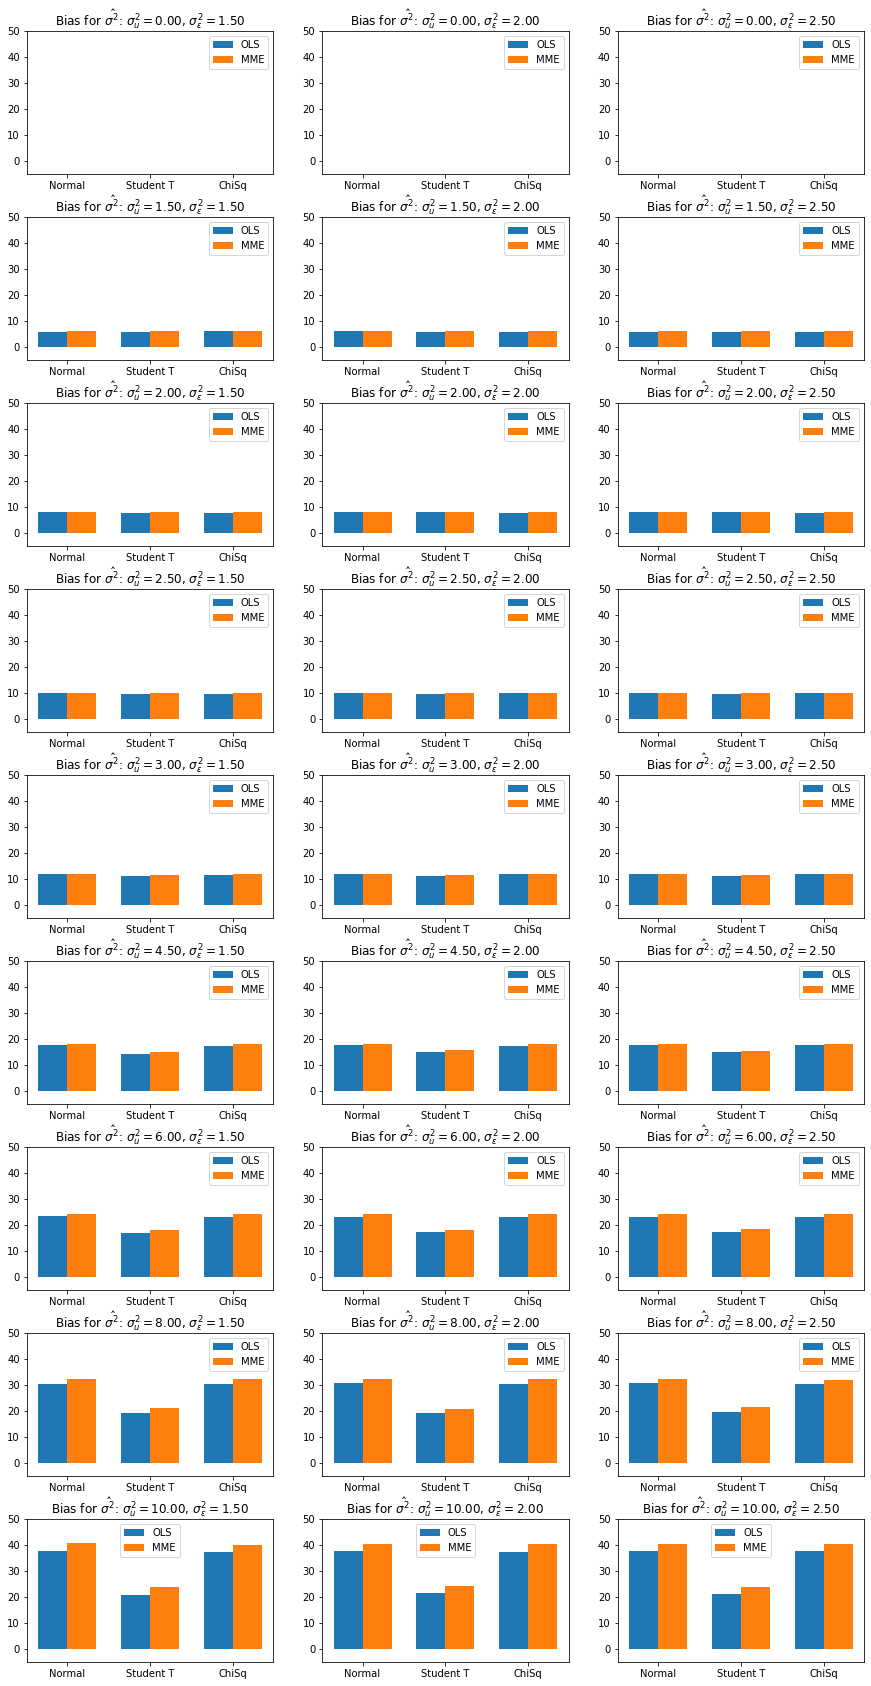

In [367]:
show_plot("Bias for $\\hat{\\sigma^2}$", [sigma_dict_normal, sigma_dict_t, sigma_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr', -5, 50.0)

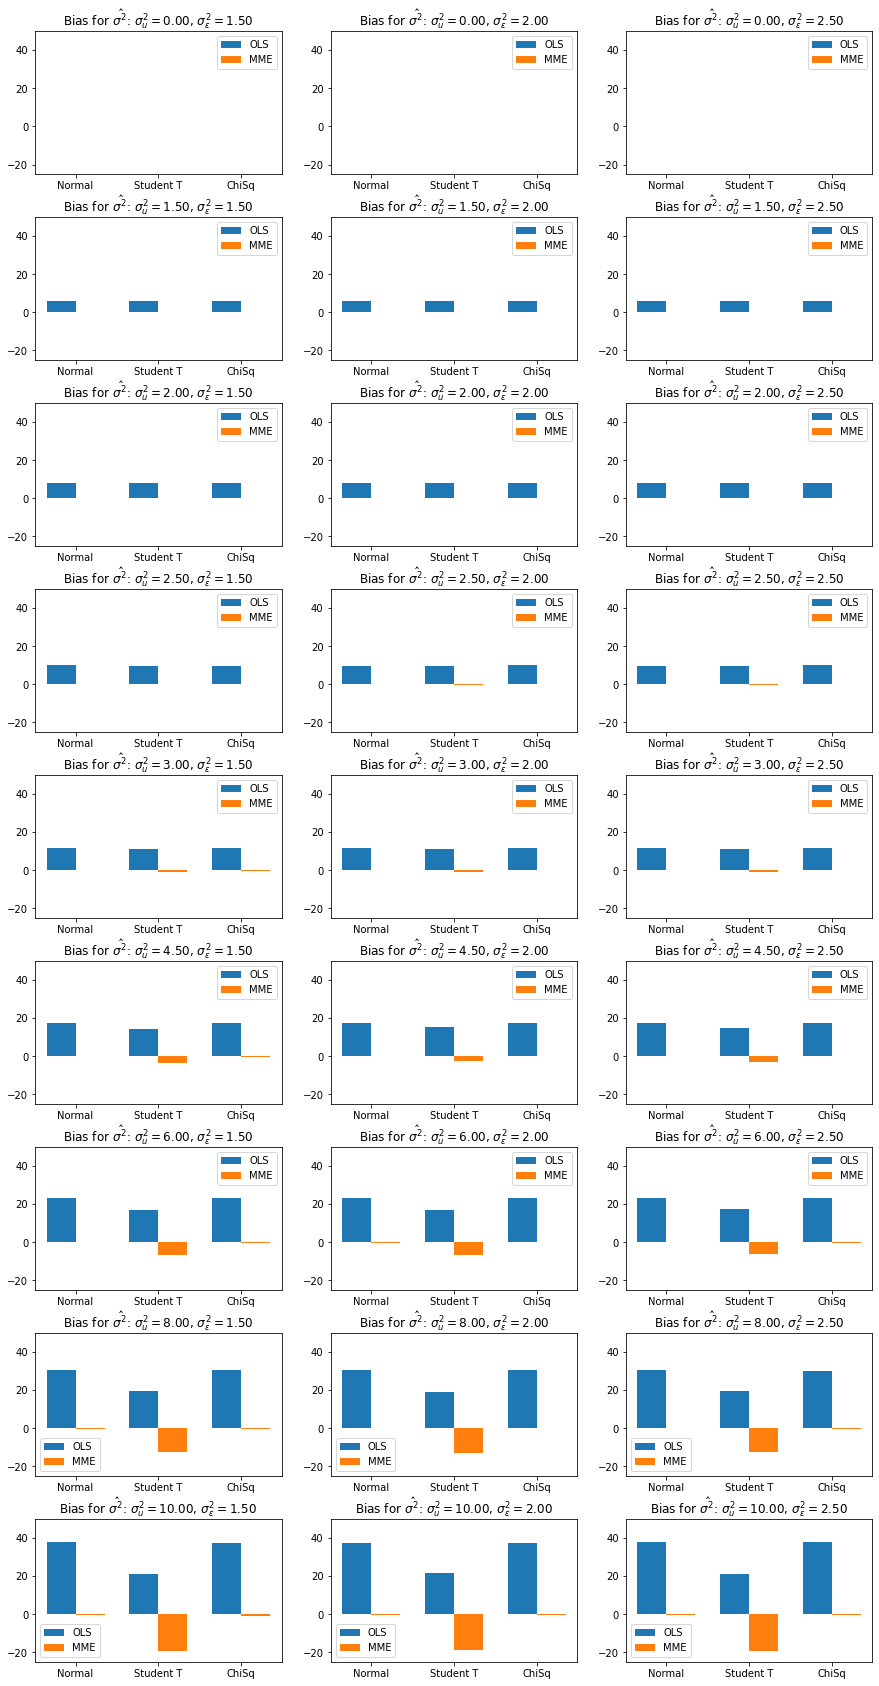

In [371]:
show_plot("Bias for $\\hat{\\sigma^2}$", [sigma_dict_normal, sigma_dict_t, sigma_dict_chi], ['Normal', 'Student T', 'ChiSq'], 'bias_ols', 'bias_ols_corr_v2', -25, 50.0)

Special property of assuming normal errors: Maximum likelihood estimation is exactly the same as OLS